# **Answering the questions**

✔️ Answer the questions below (briefly):

🌈Based on the provided template, describe the format of the input file (sdf file).

- Structure Data Format (SDF) is a file format commonly used in chemistry for storing and exchanging molecular structures, properties, and related data.
- Can contain information about individual molecules or collections of molecules
- it include information about the positions of individual atoms in a chemical molecule as well as the connections between them


🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

- data :The data is in a tokenized form and includes the nodes of the chemical molecule.The batch_size refers to the number of samples in a batch, while max_len_nodes indicates the padded length of the tokenized nodes.

- edge : it contains information about the connections between atoms.
- node2graph:It is The segmented mean input tensor contains information about segmented IDs.


🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?

- dim of gnn_out is (batch_size_node_dimension, hidden layers), where batch_size_node_dimension refers to the dimension of the input data vector (i.e., the dimension of the tokenized vector for the entire batch) and hidden layers represents the aggregation output of the model for each hidden layer.
- dim of avg is determined by calculating the segmented mean of gnn_out using the segmented IDs. Specifically, the output of gnn_out is (tokenized_vector_dimension, hidden_layers) for each sample in the batch_size, and a segment ID is assigned to each sample.


🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

- segment_mean: calculates the average of data that have the same segmented ids.

- reduce_mean: computes the mean value of elements across the specified dimensions of a tensor.
- The shape of the "pred" tensor is (num_of_graphs, num_of_units in the output layer), where the first dimension represents the number of graphs and the second dimension is the number of units in the output layer, which is 1.


🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?

- By increasing the number of trainable parameters in the network, the complexity of the model will increase, allowing it to better distinguish features in each node through a more complex hyperplane. This increased complexity can lead to more accurate results for node classification.
- the number of layers used in the template was the default number which is 4 layers.

# **Problem Formulation**

## Problem Definition

- Our goal is to create a model that can predict the effectiveness of chemical compounds against non-small cell lung cancer using complex chemical structured data. The model will be designed to distinguish between compounds that are effective and those that are not.
- input data consists of 2 feature sets: the first set represents the nodes, and the second set represents the edges between these nodes.
- output is if this chemical compound is effective 1 or not 0


## Data mining function

- classification and prediction

## Challenges

- Our dataset is stored in SDF files, which are chemical files that represent each sample as nodes and the edges that connect these nodes, along with the corresponding output. Therefore, we require a specialized function to extract the relevant information from these files.

- The data is imbalanced

## Model impact

- Addressing this medical problem has the potential to make significant progress in the field of medicine.

## The ideal solution

- Trial "9" GNN-FiLM Using RandomOverSample was the highest Test Accuracy = 88.37% with those Hyperparameters
- hidden_dim = 32, num_layers = 6, film_parameter_MLP_hidden_layers = 1

# **Importing Libraries and check data**

In [ ]:
#!pip install --quiet networkx
#!pip install --quiet tf2_gnn
#!pip install imblearn

In [ ]:
import numpy as np   
from tqdm.notebook import tqdm
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
#importing libraries for displaying network of molecule
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
#for deep Graph Neural Network
from tf2_gnn.layers.gnn import GNN, GNNInput
#importing tensorflow and other libraries
import tensorflow as tf
from tensorflow.math import segment_mean #to calculate segmented mean
from tensorflow import keras
from tensorflow.keras import Input, Model #layers and model
from tensorflow.keras.layers import Embedding, Dense, Dropout #layers
from tensorflow.keras.optimizers import Adam #optimizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import math
import pandas as pd 
import seaborn as sns
%matplotlib inline

In [ ]:
def read_sdf(file):
  #opening the file
  with open(file, 'r') as rf:
    content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((   
                        int(lnk[0])-1,   #first atom
                        int(lnk[1])-1, # zero-based index #second atom
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label #returning nodes, links and label
    #parse_sample for each molecule
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]  

In [ ]:
#reading train.sdf file
training_set = read_sdf('train.sdf')
testing_set = read_sdf('test_x.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [ ]:
np.unique(np.array(training_set)[:,2],return_counts=True)

C:\Users\DeKaiTo\AppData\Local\Temp/ipykernel_16828/852145860.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([23806,  1218], dtype=int64))

In [ ]:
#splitting the train data
training_set, validation_set = train_test_split(training_set, test_size=0.2)

In [ ]:
np.unique(np.array(training_set)[:,2],return_counts=True)

C:\Users\DeKaiTo\AppData\Local\Temp/ipykernel_16828/852145860.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.unique(np.array(training_set)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([19052,   967], dtype=int64))

In [ ]:
colors = cm.rainbow(np.linspace(0, 1, 50))

def visualize(sample):
  #initiating an instance of Graph
  G=nx.Graph()
  #all atoms as nodes
  nodes = sample[0]
  #all connections as edges
  edges = sample[1]
  #empty dictionary for labels for the all nodes
  labeldict={}
  #empty array for each node color
  node_color=[]
  for i,n in enumerate(nodes):
    #adding node to the graph each node as (0,1,2,3..)
    G.add_node(i)
    #dictionary building with [key,value] as [0:'C']
    labeldict[i]=n
    #color coding
    node_color.append(colors[hash(n)%len(colors)])

  # a list of nodes:
  for e in edges:
    #adding egde to the graph from one connection to other connection
    G.add_edge(e[0], e[1]) 

  #drawing the graph with labels for nodes as atoms and connections as edges    
  nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
  #draw the graph
  plt.show()
  #returns graph
  return G

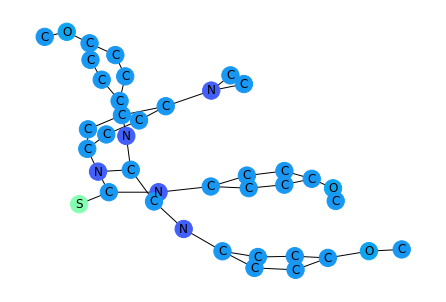

In [ ]:
#displaying one sample
plt.clf()
visualize(training_set[5])

# **Part 1: Data Preprocessing**

In [ ]:
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]

#training tokenizer
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
random.seed(0)
def prepare_single_batch(samples):
  #nodes characters array
  sample_nodes = [s[0] for s in samples]
  #tokenizing the sample nodes
  sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
  #pad_sequences for each sample node with post padding and post truncating 
  sample_nodes = pad_sequences(sample_nodes, padding='post', truncating = 'pre')
  #maximum length of nodes 
  max_nodes_len = np.shape(sample_nodes)[1]
  #defining edges
  edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
  edges = [e for e in edges if len(e) > 0]

  #array definition for segmented_ids
  node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
  
  #reshaping as 1 vector
  all_nodes = np.reshape(sample_nodes, -1)
  #concatenating all the edges as size [total_edges ,2]
  all_edges = np.concatenate(edges)

  node_to_graph = np.reshape(node_to_graph, -1)
  #returns a dictionary of features(data,edges,node2grah) and label
  return {
      'data': all_nodes,
      'edges': all_edges,
      'node2grah': node_to_graph,
  }, np.array([s[2] for s in samples])

In [ ]:
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
      dataset = list(dataset)
      if shuffle:
        #randomly shuffling
        random.shuffle(dataset)
      
      #length of dataset
      l = len(dataset)
      #for creating batches from given dataset
      for ndx in range(0, l, batch_size):
        #creating batch samples with given batch_size
        batch_samples = dataset[ndx:min(ndx + batch_size, l)]
        #returning a generator with prepared batches
        yield prepare_single_batch(batch_samples)
        
      if not repeat:
          break

In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)        
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
Shape is (228,)
edges
Shape is (126, 2)
node2grah
Shape is (228,)
label [0 1 0 0]


# **Part 2: Building The Models**

## Trial 1 Using Default Hyperparameters And not fixing the Data Imbalance

In [ ]:
#Input layer (tokenized text)
data = keras.Input(batch_shape=(None,))

# the first dim is different.it is the total number of edges in this batch

#Input for edge data
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
#Input for node2graph ids
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
#embedding over data with each token as a vector
embeded = Embedding(tokenizer.num_words, 80)(data)


# number of graphs
#calculating number of graphs
num_graph = tf.reduce_max(node2graph)+1  

#gnn_input layer with inputs as defined above
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

#defining hyperparameters for GNN layer
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)  
#outpur shape: [data_dimension,hidden layers]
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

#calculating segmented mean based on segment_ids
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

#final dense layer with sigmoid
pred = Dense(1, activation='sigmoid')(avg)
#output shape: [batch_size,1]
print('pred:', pred)

#Building The Model 
#inputs is dictionary of data, edges, node2graph
#output: prediction value from dense layer
model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
# Compile the model by using my adam optimizer and BinaryCrossentropy loss
model.compile(
    optimizer = "adam",
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32
#math.ceil: returns the smallest integral value greater than the number
#no. of batches for training data
num_batchs = math.ceil(len(training_set) / batch_size)
#no. of batches for validation data
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
hist = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)

Epoch 1/30
626/626 [==============================] - 9s 11ms/step - loss: 0.2523 - auc: 0.4823 - val_loss: 0.2039 - val_auc: 0.6819
Epoch 2/30
626/626 [==============================] - 7s 11ms/step - loss: 0.1927 - auc: 0.6100 - val_loss: 0.1822 - val_auc: 0.6764
Epoch 3/30
626/626 [==============================] - 7s 11ms/step - loss: 0.1874 - auc: 0.6451 - val_loss: 0.1819 - val_auc: 0.7160
Epoch 4/30
626/626 [==============================] - 7s 12ms/step - loss: 0.1863 - auc: 0.6484 - val_loss: 0.1813 - val_auc: 0.7083
Epoch 5/30
626/626 [==============================] - 7s 11ms/step - loss: 0.1835 - auc: 0.6713 - val_loss: 0.1795 - val_auc: 0.7297
Epoch 6/30
626/626 [==============================] - 7s 12ms/step - loss: 0.1816 - auc: 0.6849 - val_loss: 0.1673 - val_auc: 0.7482
Epoch 7/30
626/626 [==============================] - 7s 11ms/step - loss: 0.1798 - auc: 0.7003 - val_loss: 0.1726 - val_auc: 0.7445
Epoch 8/30
626/626 [==============================] - 7s 11ms/step - 

- 78.56% training AUC
- 81.08% validation AUC
It's a good start but we Still can improve it

## Trial 2 Using **Upsampling** to fix the Data Imbalance With Default Hyperparameters

In [ ]:
training_set = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

C:\Users\DeKaiTo\AppData\Local\Temp/ipykernel_9620/4094584240.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique, counts = np.unique(np.array(training_set)[:,2], return_counts=True)


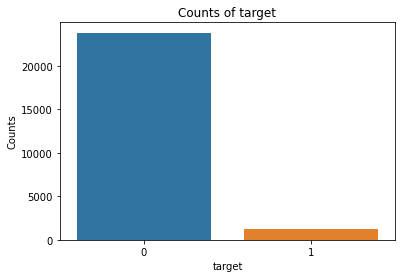

In [ ]:
unique, counts = np.unique(np.array(training_set)[:,2], return_counts=True)
maxCount=23806
sns.barplot(x=unique, y=counts)
plt.xlabel('target')
plt.ylabel('Counts')
plt.title('Counts of target')
plt.show()

In [ ]:
#convert the data from List to DataFrame to make upsampling
data = pd.DataFrame(np.array(training_set)[:,:], columns = ['0', '1', 'target'])

C:\Users\DeKaiTo\AppData\Local\Temp/ipykernel_9620/795063482.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data = pd.DataFrame(np.array(training_set)[:,:], columns = ['0', '1', 'target'])


In [ ]:
resampling = data.copy()  #take a copy of dataframe
class_0 = resampling[resampling['target']==0]   # all rows has target zero
class_1 = resampling[resampling['target']==1]   # all rows has target one
class_1_after = resample(class_1, replace=True,n_samples = maxCount)   
data_upsampled = pd.concat([class_0, class_1_after])    #add the new rows 

In [ ]:
data_upsampled['target'].value_counts()

0    23806
1    23806
Name: target, dtype: int64

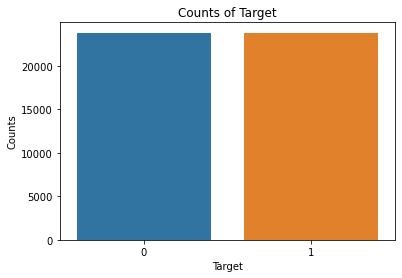

In [ ]:
sns.countplot(x='target', data=data_upsampled)
plt.xlabel('Target')
plt.ylabel('Counts')
plt.title('Counts of Target')
plt.show()

In [ ]:
#converting the upsampled DataFrame into list
training_set = data_upsampled.values.tolist()

In [ ]:
training_set, validation_set = train_test_split(training_set, test_size=0.15)

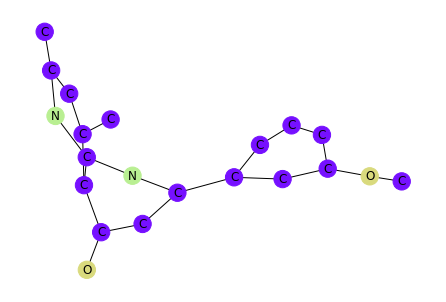

In [ ]:
#displaying one sample
plt.clf()
visualize(training_set[5])

In [ ]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes = [s[0] for s in training_set]

#training tokenizer
tokenizer = Tokenizer(num_words = max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [ ]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)  
        print("Shape is "+str(np.shape(v)))
        pass
    print('label', train_batch[1])
    break

data
Shape is (160,)
edges
Shape is (108, 2)
node2grah
Shape is (160,)
label [0 0 1 0]


In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 80)(data)


num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 40
gnn_layer = GNN(params)  
gnn_out = gnn_layer(gnn_input) 

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

model = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 40), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [ ]:
model.compile(
    optimizer = "adam",
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 32
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)
hist = model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=30,
    validation_data=gen_batch(
        validation_set, batch_size=32, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1
)


Epoch 1/30
1265/1265 [==============================] - 20s 14ms/step - loss: 0.6196 - auc: 0.7159 - val_loss: 0.5928 - val_auc: 0.7495
Epoch 2/30
1265/1265 [==============================] - 18s 14ms/step - loss: 0.5856 - auc: 0.7565 - val_loss: 0.5774 - val_auc: 0.7739
Epoch 3/30
1265/1265 [==============================] - 18s 14ms/step - loss: 0.5685 - auc: 0.7764 - val_loss: 0.5663 - val_auc: 0.7829
Epoch 4/30
1265/1265 [==============================] - 17s 14ms/step - loss: 0.5503 - auc: 0.7945 - val_loss: 0.5488 - val_auc: 0.7961
Epoch 5/30
1265/1265 [==============================] - 17s 14ms/step - loss: 0.5370 - auc: 0.8066 - val_loss: 0.5358 - val_auc: 0.8127
Epoch 6/30
1265/1265 [==============================] - 18s 14ms/step - loss: 0.5239 - auc: 0.8180 - val_loss: 0.5197 - val_auc: 0.8232
Epoch 7/30
1265/1265 [==============================] - 17s 14ms/step - loss: 0.5109 - auc: 0.8287 - val_loss: 0.5065 - val_auc: 0.8307
Epoch 8/30
1265/1265 [==========================

In [ ]:
y_pred = model.predict(
    gen_batch(testing_set, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 3s 3ms/step


In [ ]:
submission = pd.DataFrame({'label':y_pred})
submission.index.name = 'id'
submission.to_csv('Trial_2.csv')

On Kaggle It Got 0.81 Thats not very good so lets try the others

## Trial 3 Using Upsampling to fix the Data Imbalance And Changing GGNN Hyperparameters

In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 32
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model2 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model2.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                      

In [ ]:
model2.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1,restore_best_weights=True)

hist = model2.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop]
)

Epoch 1/50
633/633 [==============================] - 59s 86ms/step - loss: 0.6332 - auc: 0.6908 - val_loss: 0.5823 - val_auc: 0.7616
Epoch 2/50
633/633 [==============================] - 53s 84ms/step - loss: 0.5754 - auc: 0.7648 - val_loss: 0.5514 - val_auc: 0.7910
Epoch 3/50
633/633 [==============================] - 54s 85ms/step - loss: 0.5500 - auc: 0.7916 - val_loss: 0.5259 - val_auc: 0.8162
Epoch 4/50
633/633 [==============================] - 53s 84ms/step - loss: 0.5230 - auc: 0.8183 - val_loss: 0.5071 - val_auc: 0.8340
Epoch 5/50
633/633 [==============================] - 53s 83ms/step - loss: 0.5042 - auc: 0.8334 - val_loss: 0.4946 - val_auc: 0.8423
Epoch 6/50
633/633 [==============================] - 52s 83ms/step - loss: 0.4811 - auc: 0.8506 - val_loss: 0.4588 - val_auc: 0.8707
Epoch 7/50
633/633 [==============================] - 53s 83ms/step - loss: 0.4519 - auc: 0.8698 - val_loss: 0.4183 - val_auc: 0.8900
Epoch 8/50
633/633 [==============================] - 53s 84ms

In [ ]:
#make a prediction by using the model
y_pred_2 = model2.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_2 = np.reshape(y_pred_2, -1)

193/193 [==============================] - 5s 22ms/step


In [ ]:
submission = pd.DataFrame({'label':y_pred_2})
submission.index.name = 'id'
submission.to_csv('trial_3_GGNN.csv')

On Kaggle It Got 0.862 Thats actually very good but still will try the other HP first. So lets try RandomOverSample and see if it does better on same model

## Trial 4 Using RandomOverSample to fix the Data Imbalance And Changing GGNN Hyperparameters

In [ ]:
training_set4 = read_sdf('train.sdf')

  0%|          | 0/25024 [00:00<?, ?it/s]

C:\Users\DeKaiTo\AppData\Local\Temp/ipykernel_16828/1118175248.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  unique, counts = np.unique(np.array(training_set4)[:,2], return_counts=True)


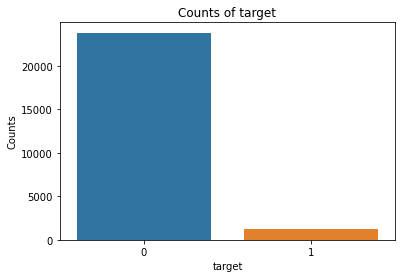

In [ ]:
unique, counts = np.unique(np.array(training_set4)[:,2], return_counts=True)

sns.barplot(x=unique, y=counts)
plt.xlabel('target')
plt.ylabel('Counts')
plt.title('Counts of target')
plt.show()

In [ ]:
#convert the data from List to DataFrame to make upsampling
data2 = pd.DataFrame(np.array(training_set4)[:,:], columns = ['0', '1', 'target'])
data2['target'] = data2['target'].astype(int)

C:\Users\DeKaiTo\AppData\Local\Temp/ipykernel_16828/1998894208.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data2 = pd.DataFrame(np.array(training_set4)[:,:], columns = ['0', '1', 'target'])


In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=44)
resampling = data2.copy()
X_resampled, y_resampled = ros.fit_resample(resampling.drop('target', axis=1), resampling['target'])
data_upsampled = pd.concat([X_resampled, y_resampled], axis=1)

In [ ]:
data_upsampled['target'].value_counts()

0    23806
1    23806
Name: target, dtype: int64

In [ ]:
#converting the upsampled DataFrame into list
training_set4 = data_upsampled.values.tolist()

In [ ]:
training_set4, validation_set4 = train_test_split(training_set4, test_size=0.2)

In [ ]:
#vocabulary size
max_vocab = 500
# maximum length of the tokenized vector
max_len = 100 

# build vocabulary from training set only for nodes characters
all_nodes3 = [s[0] for s in training_set4]

#training tokenizer
tokenizer3 = Tokenizer(num_words = max_vocab)
tokenizer3.fit_on_texts(all_nodes)

In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 32
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model3 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model3.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_3[0][0]']                
 )                                                                                                
                            

In [ ]:
model3.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64
num_batchs = math.ceil(len(training_set4) / batch_size)
num_batchs_validation = math.ceil(len(validation_set4) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)
hist = model3.fit(
    gen_batch(
        training_set4, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set4, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
596/596 [==============================] - 58s 90ms/step - loss: 0.6276 - auc: 0.6984 - val_loss: 0.5900 - val_auc: 0.7526 - lr: 0.0010
Epoch 2/50
596/596 [==============================] - 51s 86ms/step - loss: 0.5695 - auc: 0.7691 - val_loss: 0.5477 - val_auc: 0.7947 - lr: 0.0010
Epoch 3/50
596/596 [==============================] - 51s 85ms/step - loss: 0.5259 - auc: 0.8153 - val_loss: 0.5134 - val_auc: 0.8351 - lr: 0.0010
Epoch 4/50
596/596 [==============================] - 52s 87ms/step - loss: 0.4798 - auc: 0.8512 - val_loss: 0.4668 - val_auc: 0.8625 - lr: 0.0010
Epoch 5/50
596/596 [==============================] - 53s 89ms/step - loss: 0.4496 - auc: 0.8713 - val_loss: 0.4358 - val_auc: 0.8819 - lr: 0.0010
Epoch 6/50
596/596 [==============================] - 54s 90ms/step - loss: 0.4146 - auc: 0.8915 - val_loss: 0.4087 - val_auc: 0.9029 - lr: 0.0010
Epoch 7/50
596/596 [==============================] - 55s 93ms/step - loss: 0.3848 - auc: 0.9069 - val_loss: 0.3743 - 

In [ ]:
#make a prediction by using the model
y_pred_4 = model3.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_4 = np.reshape(y_pred_4, -1)

193/193 [==============================] - 4s 23ms/step


In [ ]:
submission = pd.DataFrame({'label':y_pred_4})
submission.index.name = 'id'
submission.to_csv('trial_4_Random_GGNN.csv')

It Was better on kaggle With 0.8727 so Will go with randomOversample and try different HP

## Trial 5 Using RandomOverSample to fix the Data Imbalance And Changing RGCN Hyperparameters

In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGCN'
params["hidden_dim"] = 32
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model4 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model4.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_6[0][0]']                
 da)                                                                                              
                      

In [ ]:
model4.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [ ]:
batch_size = 64
num_batchs = math.ceil(len(training_set4) / batch_size)
num_batchs_validation = math.ceil(len(validation_set4) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)
hist = model4.fit(
    gen_batch(
        training_set4, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set4, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
596/596 [==============================] - 28s 41ms/step - loss: 0.6269 - auc: 0.6985 - val_loss: 0.6215 - val_auc: 0.7250 - lr: 0.0010
Epoch 2/50
596/596 [==============================] - 25s 41ms/step - loss: 0.5933 - auc: 0.7400 - val_loss: 0.5849 - val_auc: 0.7530 - lr: 0.0010
Epoch 3/50
596/596 [==============================] - 24s 41ms/step - loss: 0.5779 - auc: 0.7561 - val_loss: 0.5814 - val_auc: 0.7673 - lr: 0.0010
Epoch 4/50
596/596 [==============================] - 24s 40ms/step - loss: 0.5658 - auc: 0.7703 - val_loss: 0.5636 - val_auc: 0.7802 - lr: 0.0010
Epoch 5/50
596/596 [==============================] - 24s 40ms/step - loss: 0.5567 - auc: 0.7816 - val_loss: 0.5528 - val_auc: 0.7895 - lr: 0.0010
Epoch 6/50
596/596 [==============================] - 25s 42ms/step - loss: 0.5466 - auc: 0.7926 - val_loss: 0.5525 - val_auc: 0.7978 - lr: 0.0010
Epoch 7/50
596/596 [==============================] - 25s 42ms/step - loss: 0.5339 - auc: 0.8063 - val_loss: 0.5320 - 

Not That Great the GGNN Was better, But lets try the other HP

## Trial 6 Using RandomOverSample to fix the Data Imbalance And Changing RGAT Hyperparameters

In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGAT'
params["hidden_dim"] = 32
params["num_layers"] = 6
params["num_heads"] = 8


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model5 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model5.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model5.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_2/StatefulPartitionedCall:0', description="created by layer 'gnn_2'")
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                      

In [ ]:
batch_size = 64
num_batchs = math.ceil(len(training_set4) / batch_size)
num_batchs_validation = math.ceil(len(validation_set4) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
hist = model5.fit(
    gen_batch(
        training_set4, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set4, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
596/596 [==============================] - 43s 58ms/step - loss: 0.6312 - auc: 0.6944 - val_loss: 0.6091 - val_auc: 0.7334 - lr: 0.0010
Epoch 2/50
596/596 [==============================] - 33s 56ms/step - loss: 0.5983 - auc: 0.7382 - val_loss: 0.5933 - val_auc: 0.7455 - lr: 0.0010
Epoch 3/50
596/596 [==============================] - 33s 55ms/step - loss: 0.5806 - auc: 0.7590 - val_loss: 0.5704 - val_auc: 0.7718 - lr: 0.0010
Epoch 4/50
596/596 [==============================] - 33s 56ms/step - loss: 0.5572 - auc: 0.7838 - val_loss: 0.5558 - val_auc: 0.7879 - lr: 0.0010
Epoch 5/50
596/596 [==============================] - 33s 55ms/step - loss: 0.5385 - auc: 0.8020 - val_loss: 0.5359 - val_auc: 0.8041 - lr: 0.0010
Epoch 6/50
596/596 [==============================] - 34s 57ms/step - loss: 0.5205 - auc: 0.8171 - val_loss: 0.5137 - val_auc: 0.8236 - lr: 0.0010
Epoch 7/50
596/596 [==============================] - 33s 55ms/step - loss: 0.5103 - auc: 0.8263 - val_loss: 0.5060 - 

In [ ]:
#make a prediction
y_pred_5 = model5.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_5 = np.reshape(y_pred_5, -1)
submission = pd.DataFrame({'label':y_pred_5})
submission.index.name = 'id'
submission.to_csv('trial_6_RGAT.csv')

193/193 [==============================] - 4s 15ms/step


Still not better, Lets Continue

## Trial 7 Using RandomOverSample to fix the Data Imbalance And Changing RGIN Hyperparameters

In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'RGIN'
params["hidden_dim"] = 32
params["num_layers"] = 6
params["num_aggr_MLP_hidden_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model6 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model6.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model6.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_3/StatefulPartitionedCall:0', description="created by layer 'gnn_3'")
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_3 (TFOpLamb  ()                  0           ['input_12[0][0]']               
 da)                                                                                              
                      

In [ ]:
batch_size = 64
num_batchs = math.ceil(len(training_set4) / batch_size)
num_batchs_validation = math.ceil(len(validation_set4) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.0001)
hist = model6.fit(
    gen_batch(
        training_set4, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set4, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
596/596 [==============================] - 49s 73ms/step - loss: 0.6641 - auc: 0.6296 - val_loss: 0.6462 - val_auc: 0.6596 - lr: 0.0010
Epoch 2/50
596/596 [==============================] - 41s 68ms/step - loss: 0.6334 - auc: 0.6862 - val_loss: 0.6519 - val_auc: 0.6951 - lr: 0.0010
Epoch 3/50
596/596 [==============================] - 40s 67ms/step - loss: 0.6178 - auc: 0.7104 - val_loss: 0.6169 - val_auc: 0.7211 - lr: 0.0010
Epoch 4/50
596/596 [==============================] - 39s 66ms/step - loss: 0.6118 - auc: 0.7195 - val_loss: 0.6098 - val_auc: 0.7231 - lr: 0.0010
Epoch 5/50
596/596 [==============================] - 39s 66ms/step - loss: 0.6101 - auc: 0.7221 - val_loss: 0.6076 - val_auc: 0.7297 - lr: 0.0010
Epoch 6/50
596/596 [==============================] - 39s 65ms/step - loss: 0.6063 - auc: 0.7274 - val_loss: 0.6035 - val_auc: 0.7306 - lr: 0.0010
Epoch 7/50
596/596 [==============================] - 39s 66ms/step - loss: 0.5941 - auc: 0.7396 - val_loss: 0.5956 - 

57.4% AUC And 76.65% Validation_AUC


Ouch, Moving on.

## Trial 8 Using RandomOverSample to fix the Data Imbalance And Changing GNN-Edge-MLP Hyperparameters

In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'gnn_edge_mlp'
params["hidden_dim"] = 32
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model7 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model7.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model7.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_4/StatefulPartitionedCall:0', description="created by layer 'gnn_4'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                      

In [ ]:
batch_size = 64
num_batchs = math.ceil(len(training_set4) / batch_size)
num_batchs_validation = math.ceil(len(validation_set4) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)
hist = model7.fit(
    gen_batch(
        training_set4, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set4, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
596/596 [==============================] - 29s 43ms/step - loss: 0.6249 - auc: 0.6992 - val_loss: 0.6098 - val_auc: 0.7366 - lr: 0.0010
Epoch 2/50
596/596 [==============================] - 24s 41ms/step - loss: 0.5959 - auc: 0.7379 - val_loss: 0.5995 - val_auc: 0.7395 - lr: 0.0010
Epoch 3/50
596/596 [==============================] - 24s 41ms/step - loss: 0.5848 - auc: 0.7494 - val_loss: 0.5796 - val_auc: 0.7582 - lr: 0.0010
Epoch 4/50
596/596 [==============================] - 24s 41ms/step - loss: 0.5693 - auc: 0.7664 - val_loss: 0.5645 - val_auc: 0.7782 - lr: 0.0010
Epoch 5/50
596/596 [==============================] - 25s 41ms/step - loss: 0.5580 - auc: 0.7787 - val_loss: 0.5602 - val_auc: 0.7921 - lr: 0.0010
Epoch 6/50
596/596 [==============================] - 25s 41ms/step - loss: 0.5420 - auc: 0.7956 - val_loss: 0.5497 - val_auc: 0.8006 - lr: 0.0010
Epoch 7/50
596/596 [==============================] - 25s 41ms/step - loss: 0.5307 - auc: 0.8087 - val_loss: 0.5203 - 

Better than the previous one but will try to get a better one

## Trial 9 Using RandomOverSample to fix the Data Imbalance And Changing GNN-FiLM Hyperparameters

In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GNN_FiLM'
params["hidden_dim"] = 32
params["num_layers"] = 6
params["film_parameter_MLP_hidden_layers"] = 1


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model8 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model8.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model8.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_5/StatefulPartitionedCall:0', description="created by layer 'gnn_5'")
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_18[0][0]']               
 da)                                                                                              
                      

In [ ]:
batch_size = 64
num_batchs = math.ceil(len(training_set4) / batch_size)
num_batchs_validation = math.ceil(len(validation_set4) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1, min_lr=0.00005)
hist = model8.fit(
    gen_batch(
        training_set4, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set4, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
596/596 [==============================] - 37s 55ms/step - loss: 0.6192 - auc: 0.7128 - val_loss: 0.5644 - val_auc: 0.7812 - lr: 0.0010
Epoch 2/50
596/596 [==============================] - 32s 54ms/step - loss: 0.5419 - auc: 0.8028 - val_loss: 0.5316 - val_auc: 0.8188 - lr: 0.0010
Epoch 3/50
596/596 [==============================] - 31s 53ms/step - loss: 0.5026 - auc: 0.8353 - val_loss: 0.5897 - val_auc: 0.8235 - lr: 0.0010
Epoch 4/50
596/596 [==============================] - 31s 52ms/step - loss: 0.4597 - auc: 0.8654 - val_loss: 0.4263 - val_auc: 0.8873 - lr: 0.0010
Epoch 5/50
596/596 [==============================] - 31s 52ms/step - loss: 0.3988 - auc: 0.9006 - val_loss: 0.3842 - val_auc: 0.9134 - lr: 0.0010
Epoch 6/50
596/596 [==============================] - 30s 50ms/step - loss: 0.3534 - auc: 0.9217 - val_loss: 0.3400 - val_auc: 0.9273 - lr: 0.0010
Epoch 7/50
596/596 [==============================] - 30s 50ms/step - loss: 0.3159 - auc: 0.9365 - val_loss: 0.3119 - 

In [ ]:
#make a prediction
y_pred_8 = model8.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_8 = np.reshape(y_pred_8, -1)
submission = pd.DataFrame({'label':y_pred_8})
submission.index.name = 'id'
submission.to_csv('trial_9_film.csv')

193/193 [==============================] - 3s 13ms/step


It got a score of 88.37% on Kaggle and that is by far the best accuracy I Got, but we will try onc last Trial before call an End

## Trial 10 Using RandomOverSample to fix the Data Imbalance And Using ggnn Hyperparameters and Changing some Other Hyperparameters

In [ ]:
data = keras.Input(batch_shape=(None,))

edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)

embeded = Embedding(tokenizer3.num_words, 80)(data)

num_graph = tf.reduce_max(node2graph)+1  

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

params = GNN.get_default_hyperparameters()
params["message_calculation_class"] = 'GGNN'
params["hidden_dim"] = 128
params["num_layers"] = 6


gnn_layer = GNN(params) 

gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)           

avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
    )

l1 = Dense(128,activation='relu')(avg)
l2 = Dense(64,activation='relu')(l1)
pred = Dense(1, activation='sigmoid')(l2)


model9 = Model(
    inputs={
        'data': data, 
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
model9.compile(
    optimizer = 'adam', 
    loss='BinaryCrossentropy',
    metrics=['AUC']
)
model9.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 128), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_6 (TFOpLamb  ()                  0           ['input_21[0][0]']               
 da)                                                                                              
                     

In [ ]:
batch_size = 64
num_batchs = math.ceil(len(training_set4) / batch_size)
num_batchs_validation = math.ceil(len(validation_set4) / batch_size)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00005)
hist = model9.fit(
    gen_batch(
        training_set4, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch=num_batchs,
    epochs=50,
    validation_data=gen_batch(
        validation_set4, batch_size=64, repeat=True
    ),
    validation_steps=num_batchs_validation,
    verbose=1,callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
596/596 [==============================] - 218s 359ms/step - loss: 0.6268 - auc: 0.7005 - val_loss: 0.5874 - val_auc: 0.7582 - lr: 0.0010
Epoch 2/50
596/596 [==============================] - 212s 356ms/step - loss: 0.5363 - auc: 0.8073 - val_loss: 0.5010 - val_auc: 0.8416 - lr: 0.0010
Epoch 3/50
596/596 [==============================] - 214s 358ms/step - loss: 0.4762 - auc: 0.8535 - val_loss: 0.4662 - val_auc: 0.8599 - lr: 0.0010
Epoch 4/50
596/596 [==============================] - 213s 357ms/step - loss: 0.4393 - auc: 0.8775 - val_loss: 0.4173 - val_auc: 0.8906 - lr: 0.0010
Epoch 5/50
596/596 [==============================] - 213s 358ms/step - loss: 0.3964 - auc: 0.9015 - val_loss: 0.4298 - val_auc: 0.8968 - lr: 0.0010
Epoch 6/50
596/596 [==============================] - 212s 355ms/step - loss: 0.3532 - auc: 0.9223 - val_loss: 0.3679 - val_auc: 0.9238 - lr: 0.0010
Epoch 7/50
596/596 [==============================] - 212s 356ms/step - loss: 0.3162 - auc: 0.9378 - val_l

In [ ]:
#make a prediction
y_pred_9 = model9.predict(
    gen_batch(testing_set, batch_size=64, shuffle=False)
)
y_pred_9 = np.reshape(y_pred_9, -1)

193/193 [==============================] - 20s 101ms/step


In [ ]:
submission = pd.DataFrame({'label':y_pred_9})
submission.index.name = 'id'
submission.to_csv('trial_10_GGNNhyper.csv')

When I Saw the Result on Kaggle it is obvious that it overfitted the data so the generalization Error was large

# **Result**

After Doing the 10 Trials with Different Hyperparameters The Best one I Got with low Generalization Error was The 9th Trial Using GNN-FiLM with Test Accuracy = 88.37% And maybe I Could Get better result with fine tunning more but we will keep it for now 